# Python Toolkit of Statistics for Pairwise Interactions (pyspi): an introduction
### Presented by: Annie Bryant
### CNS 2022
### 16 July 2022

In this tutorial, we will be applying `pyspi` to data derived from the [UCLA Consortium for Neuropyschiatric Phenomics LA5c Study](https://openneuro.org/datasets/ds000030/versions/00016), which is an open-access data source. We will focus on blood oxygen level-dependent signaling (BOLD) time-series derived from functional magnetic resonance imaging (fMRI). The data used in this tutorial is four sets of four brain regions derived from an anonymous participant. All fMRI time-series in this dataset are comprised of 152 time points each.

## Preparing the environment

#### Load all the modules needed for this demo

In [23]:
import pandas as pd
import numpy as np
import pickle
import dill
from os import chdir, getcwd
from scipy.stats import zscore
from scipy.signal import detrend
import matplotlib.pyplot as plt # For plotting
from scipy.stats import zscore
import seaborn as sns
from pyspi.calculator import Calculator
from matplotlib import colors, cm
from copy import deepcopy


## Preparing the fMRI multivariate time-series (MTS) data

In [38]:
# Load in the four sets (each 4 ROIs with 152 time points) of raw BOLD fMRI time-series data
BOLD_fMRI_TS_set1 = pd.read_csv("tutorial_example_data/BOLD_fMRI_TS_set1.csv",
                   header = None)

BOLD_fMRI_TS_set2 = pd.read_csv("tutorial_example_data/BOLD_fMRI_TS_set2.csv",
                   header = None)

BOLD_fMRI_TS_set3 = pd.read_csv("tutorial_example_data/BOLD_fMRI_TS_set3.csv",
                   header = None)

BOLD_fMRI_TS_set4 = pd.read_csv("tutorial_example_data/BOLD_fMRI_TS_set4.csv",
                   header = None)


# We can arbitrarily label our brain regions ROI1, ROI2, ROI3, ROI4
region_labels = ["ROI1", "ROI2", "ROI3", "ROI4"]

Let's view the first set to see how the data is set up:

In [25]:
BOLD_fMRI_TS_set1

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,1.550,0.824,-0.0862,0.721,-0.3230,0.711,0.872,-0.5140,-1.0900,-0.0672,...,0.749,-1.470,0.264,0.722,0.178,-2.200,-1.480,-0.218,-0.9720,1.3300
1,0.758,-0.303,-1.0500,-1.570,0.0527,-0.256,-0.353,0.0631,0.4280,-0.4430,...,-0.829,-0.965,-0.541,0.851,0.294,0.215,-0.121,0.138,1.6700,-0.6230
2,-0.152,-0.155,-0.6720,1.680,0.0934,0.243,-1.410,-1.5700,1.5800,0.4240,...,-2.020,-0.670,-1.070,-0.806,-0.549,1.970,1.190,0.322,-0.3950,-0.3190
3,0.274,-0.663,-1.1000,-1.460,-0.6230,-1.290,-0.979,0.4060,-0.0301,0.0555,...,1.070,1.950,0.637,0.192,0.982,-0.718,-1.260,-0.156,0.0423,0.0351


As the printed dataframe shows, the data is 4 rows by 152 columns -- corresponding to 4 brain regions by 152 time points. This is the format that `pyspi` expects: processes (e.g. brain regions) as the rows, time-points as the columns. If you have different input data that is transposed, you can easily transpose the `pandas DataFrame` using the [`transpose()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html) function.  

We can view the raw time-series values for this first set of regions:

<Figure size 432x288 with 0 Axes>

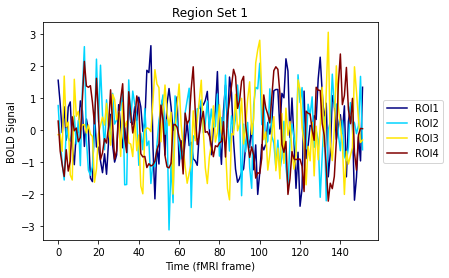

In [26]:
def plot_data_lines(data, labels, title):
    plt.figure()
    data.transpose().plot(colormap=cm.jet)

    ax = plt.gca()
    ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Time (fMRI frame)')
    plt.ylabel('BOLD Signal')
    plt.show()
    
plot_data_lines(BOLD_fMRI_TS_set1, title="Region Set 1", labels = region_labels)

We can also view the time series for this first set of brain regions as a heatmap:

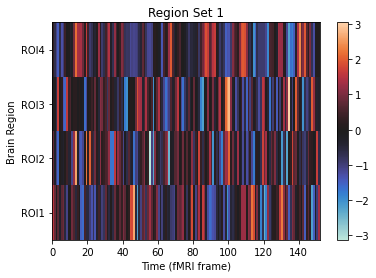

In [27]:
# Plotting the data
def plot_data_heatmap(data, labels, title):
    plt.subplots()
    plt.pcolormesh(data,cmap=sns.color_palette('icefire',as_cmap=True))
    plt.colorbar()
    plt.title(title)
    ticks = [t+0.5 for t in range(len(labels))]
    plt.yticks(ticks=ticks, labels=labels)
    plt.xlabel('Time (fMRI frame)')
    plt.ylabel('Brain Region')
    plt.show()

plot_data_heatmap(BOLD_fMRI_TS_set1, labels = region_labels, title="Region Set 1")


You can use the same functions -- `plot_data_lines()` and `plot_data_heatmap()` to visualize the raw time-series data for other three sets of regions.

## Run pyspi

Our data is now ready to process with pyspi. There are two steps to run pyspi and extract all of our pairwise statistics:  
1. Initialize the `Calculator` object; and
2. Compute the `Calculator` object. 

In the first step, you have some flexibility to play around with which SPIs you want to compute from the input time-series data. By default, `pyspi` will use all 249 available SPIs. However, this can take a long time depending on how many observations you have. If you want to give `pyspi` a try with a reduced feature set that runs quickly, you can add the boolean flag `fast=True` (which we will use for the sake of time in this tutorial).

In [39]:
# These two lines show the main usage of the calculator: simply instantiate and compute.
# Note the use of the fast=True flag
# First ensure there is no NA in the dataset
BOLD_fMRI_TS_set1 = np.nan_to_num(BOLD_fMRI_TS_set1)

calc_set1 = Calculator(BOLD_fMRI_TS_set1, fast=True)

# Compute the instantiated Calculator object
calc_set1.compute()

Loading configuration file: /home/osboxes/anaconda3/envs/pyspi/lib/python3.9/site-packages/pyspi/fast_config.yaml


Processing [None: cov_GraphicalLassoCV]:   0%|          | 0/215 [00:00<?, ?it/s]   

*** Importing module .statistics.basic
[0] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'EmpiricalCovariance'})...
Succesfully initialised SPI with identifier "cov_EmpiricalCovariance" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[1] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLasso'})...
Succesfully initialised SPI with identifier "cov_GraphicalLasso" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[2] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLassoCV'})...
Succesfully initialised SPI with identifier "cov_GraphicalLassoCV" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[3] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'LedoitWolf'})...
Succesfully initialised SPI with identifier "cov_LedoitWolf" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[4] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'OAS'})...
Succesfully in

Processing [None: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  34%|███▍      | 73/215 [00:06<00:26,  5.43it/s]Mean of empty slice
Processing [None: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  35%|███▍      | 75/215 [00:06<00:20,  6.80it/s]    All-NaN slice encountered
Processing [None: pec_orth_log_abs]: 100%|██████████| 215/215 [00:18<00:00, 11.81it/s]                                      


If you want to use the pre-compuated `calc_set1` object, you can simply load it in from the `pyspi_calc_set1.pkl` file:

In [29]:
with open('tutorial_example_data/pyspi_calc_set1.pkl','rb') as f:
    calc_set1 = dill.load(f)


We can inspect the resulting statistical pairwise interactions (SPIs) using the `calc_set1.table` object:

In [30]:
print(calc_set1.table)

spi     cov_EmpiricalCovariance                                \
process                  proc-0    proc-1    proc-2    proc-3   
proc-0                      NaN -0.200080 -0.324503  0.037373   
proc-1                -0.200080       NaN  0.083032  0.009395   
proc-2                -0.324503  0.083032       NaN -0.298659   
proc-3                 0.037373  0.009395 -0.298659       NaN   

spi     cov_GraphicalLasso                               cov_GraphicalLassoCV  \
process             proc-0    proc-1    proc-2    proc-3               proc-0   
proc-0                 NaN -0.190081 -0.314502  0.047373                  NaN   
proc-1           -0.190081       NaN  0.073032 -0.000605            -0.121997   
proc-2           -0.314502  0.073032       NaN -0.288659            -0.246421   
proc-3            0.047373 -0.000605 -0.288659       NaN             0.054715   

spi                ... pec_orth_log           pec_orth_abs            \
process    proc-1  ...       proc-2    proc-3     

This output contains the resulting values from all of the 215 SPIs concatenated together. We can view the list of SPIs that we calculated:

In [31]:
calc_set1.spis.keys()

dict_keys(['cov_EmpiricalCovariance', 'cov_GraphicalLasso', 'cov_GraphicalLassoCV', 'cov_LedoitWolf', 'cov_OAS', 'cov_ShrunkCovariance', 'cov-sq_EmpiricalCovariance', 'cov-sq_GraphicalLasso', 'cov-sq_LedoitWolf', 'cov-sq_OAS', 'cov-sq_ShrunkCovariance', 'prec_EmpiricalCovariance', 'prec_GraphicalLasso', 'prec_LedoitWolf', 'prec_OAS', 'prec_ShrunkCovariance', 'prec-sq_EmpiricalCovariance', 'prec-sq_GraphicalLasso', 'prec-sq_LedoitWolf', 'prec-sq_OAS', 'prec-sq_ShrunkCovariance', 'spearmanr-sq', 'spearmanr', 'kendalltau-sq', 'kendalltau', 'xcorr_max_sig-True', 'xcorr-sq_max_sig-True', 'xcorr_mean_sig-True', 'xcorr-sq_mean_sig-True', 'xcorr_mean_sig-False', 'xcorr-sq_mean_sig-False', 'pdist_euclidean', 'pdist_cityblock', 'pdist_cosine', 'pdist_chebyshev', 'pdist_canberra', 'pdist_braycurtis', 'dcorr', 'dcorr_biased', 'hsic', 'hsic_biased', 'bary_euclidean_mean', 'bary_euclidean_max', 'bary-sq_euclidean_mean', 'bary-sq_euclidean_max', 'anm', 'cds', 'reci', 'igci', 'je_gaussian', 'je_kozach

We can isolate one of these SPIs and visualize the results across brain regions:

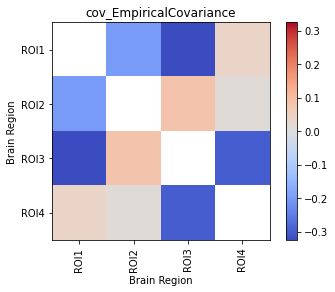

In [32]:
def plot_mpi(S,identifier,labels,ax=None):
    """ Plot a given matrix of pairwise interactions, annotating the process labels and identifier
    """
    if ax is None:
        _, ax = plt.subplots()
    plt.sca(ax)

    # Use a diverging cmap if our statistic goes negative (and a sequential cmap otherwise)
    if np.nanmin(S) < 0.:
        maxabsval = max(abs(np.nanmin(S)),abs(np.nanmax(S)))
        norm = colors.Normalize(vmin=-maxabsval, vmax=maxabsval)
        plt.imshow(S,cmap='coolwarm',norm=norm)
    else:
        plt.imshow(S,cmap='Reds',vmin=0)

    plt.xticks(ticks=range(len(labels)),labels=labels,rotation=90)
    plt.yticks(ticks=range(len(labels)),labels=labels)
    plt.xlabel('Brain Region')
    plt.ylabel('Brain Region')
    plt.title(identifier)
    plt.colorbar()


# Plot this dataframe
plot_mpi(S = calc_set1.table["cov_EmpiricalCovariance"], identifier = "cov_EmpiricalCovariance", labels = region_labels)

### Running pyspi for multiple datasets

In the above section, we ran through the `pyspi` pipeline for one dataset. In practice, you may have several datasets that you wish to process with `pyspi`, so we can cover tips for iterative processing.

In [33]:
# Create a dictionary containing our other three datasets to process
datasets_to_process = {"Set2": BOLD_fMRI_TS_set2,
            "Set3": BOLD_fMRI_TS_set3,
            "Set4": BOLD_fMRI_TS_set4}

# We can initialise one calculator and copy it for each dataset to save time
calc = Calculator(fast = True)

results = {}

# Iterate over each dataset
for key in datasets_to_process:

    # Copy the top-level calculator
    mycalc = deepcopy(calc)

    # Name the calculator after the ROI set
    mycalc.name = key[0]
    
    # Ensure we have no NaNs in our dataset
    dataset = np.nan_to_num(datasets_to_process[key])

    # Load the dataset
    mycalc.load_dataset(dataset)

    # Compute all pairwise interactions
    mycalc.compute()

    # Store our results
    results[key] = mycalc.table

Loading configuration file: /home/osboxes/anaconda3/envs/pyspi/lib/python3.9/site-packages/pyspi/fast_config.yaml


Processing [S: cov_GraphicalLassoCV]:   0%|          | 0/215 [00:00<?, ?it/s]   

*** Importing module .statistics.basic
[0] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'EmpiricalCovariance'})...
Succesfully initialised SPI with identifier "cov_EmpiricalCovariance" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[1] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLasso'})...
Succesfully initialised SPI with identifier "cov_GraphicalLasso" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[2] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLassoCV'})...
Succesfully initialised SPI with identifier "cov_GraphicalLassoCV" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[3] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'LedoitWolf'})...
Succesfully initialised SPI with identifier "cov_LedoitWolf" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[4] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'OAS'})...
Succesfully in

Processing [S: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  33%|███▎      | 72/215 [00:04<00:13, 10.47it/s]Mean of empty slice
Processing [S: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  35%|███▍      | 75/215 [00:04<00:11, 12.70it/s]    All-NaN slice encountered
Processing [S: pec_orth_log_abs]: 100%|██████████| 215/215 [00:11<00:00, 18.64it/s]                                      
Processing [S: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  33%|███▎      | 72/215 [00:07<00:28,  5.04it/s]Mean of empty slice
Processing [S: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  35%|███▍      | 75/215 [00:07<00:21,  6.57it/s]    All-NaN slice encountered
Processing [S: pec_orth_log_abs]: 100%|██████████| 215/215 [00:14<00:00, 14.56it/s]                                      
Processing [S: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  33%|███▎      | 72/215 [00:07<00:31,  4.60it/s]Mean of empty slice
Processing [S: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  35%|███▍      | 75/215 [00:07<00:22,  

This combines the SPI tables from each set into a dictionary. This step takes about 2 minutes to run, so if you want to skip this part, you can load the pre-computed `results` dictionary as follows:

In [34]:
with open('tutorial_example_data/three_sets_results.pkl','rb') as f:
    results = dill.load(f)


We can concatenate the dictionary of dataframes into one large dataframe as follows:

In [35]:
df_all_results = pd.concat(results, axis=0)
df_all_results

spi         cov_EmpiricalCovariance                                \
process                      proc-0    proc-1    proc-2    proc-3   
Set2 proc-0                     NaN  0.156953  0.018860  0.110361   
     proc-1                0.156953       NaN  0.311516  0.339494   
     proc-2                0.018860  0.311516       NaN  0.058426   
     proc-3                0.110361  0.339494  0.058426       NaN   
Set3 proc-0                     NaN  0.060109  0.061705 -0.177440   
     proc-1                0.060109       NaN -0.141346  0.564216   
     proc-2                0.061705 -0.141346       NaN -0.306127   
     proc-3               -0.177440  0.564216 -0.306127       NaN   
Set4 proc-0                     NaN -0.055438  0.527350 -0.097201   
     proc-1               -0.055438       NaN -0.154825 -0.046011   
     proc-2                0.527350 -0.154825       NaN -0.160583   
     proc-3               -0.097201 -0.046011 -0.160583       NaN   

spi         cov_GraphicalLasso                                \
process                 proc-0    proc-1    proc-2    proc-3   
Set2 proc-0                NaN  0.146953  0.028862  0.100361   
     proc-1           0.146953       NaN  0.301515  0.329494   
     proc-2           0.028862  0.301515       NaN  0.068426   
     proc-3           0.100361  0.329494  0.068426       NaN   
Set3 proc-0                NaN  0.050109  0.052820 -0.167440   
     proc-1           0.050109       NaN -0.151339  0.554216   
     proc-2           0.052820 -0.151339       NaN -0.296127   
     proc-3          -0.167440  0.554216 -0.296127       NaN   
Set4 proc-0                NaN -0.065441  0.517350 -0.087201   
     proc-1          -0.065441       NaN -0.144825 -0.036011   
     proc-2           0.517350 -0.144825       NaN -0.150583   
     proc-3          -0.087201 -0.036011 -0.150583       NaN   

spi         cov_GraphicalLassoCV            ... pec_orth_log            \
process                   proc-0    proc-1  ...       proc-2    proc-3   
Set2 proc-0                  NaN  0.089006  ...    -0.069433 -0.115505   
     proc-1             0.089006       NaN  ...    -0.103117 -0.016674   
     proc-2             0.021823  0.243569  ...          NaN -0.060454   
     proc-3             0.042415  0.271548  ...    -0.060454       NaN   
Set3 proc-0                  NaN  0.016244  ...    -0.056113 -0.022465   
     proc-1             0.016244       NaN  ...     0.053990  0.032731   
     proc-2             0.035264 -0.137372  ...          NaN -0.029218   
     proc-3            -0.133576  0.520352  ...    -0.029218       NaN   
Set4 proc-0                  NaN -0.061407  ...    -0.001309 -0.013857   
     proc-1            -0.061407       NaN  ...    -0.004404 -0.046851   
     proc-2             0.495672 -0.123147  ...          NaN  0.105570   
     proc-3            -0.065523 -0.014332  ...     0.105570       NaN   

spi         pec_orth_abs                               pec_orth_log_abs  \
process           proc-0    proc-1    proc-2    proc-3           proc-0   
Set2 proc-0          NaN  0.075242  0.079166  0.098287              NaN   
     proc-1     0.075242       NaN  0.099665  0.043631         0.057794   
     proc-2     0.079166  0.099665       NaN  0.108011         0.069433   
     proc-3     0.098287  0.043631  0.108011       NaN         0.115505   
Set3 proc-0          NaN  0.026405  0.027308  0.050367              NaN   
     proc-1     0.026405       NaN  0.074690  0.033175         0.034731   
     proc-2     0.027308  0.074690       NaN  0.029645         0.056113   
     proc-3     0.050367  0.033175  0.029645       NaN         0.069316   
Set4 proc-0          NaN  0.013848  0.046227  0.127308              NaN   
     proc-1     0.013848       NaN  0.101799  0.128125         0.038239   
     proc-2     0.046227  0.101799       NaN  0.120285         0.039605   
     proc-3     0.127308  0.128125  0.120285       NaN         0.095772   

spi                                        
proc

## Downstream analysis

### Exporting data to R

For users who use R for data wrangling and visualization, we can save the `pyspi` output to a pickle file (`.pkl`) and write a custom function to read this into R with the `reticulate()` package. We can practice with the `calc_set1` results, by first saving `calc_set1.table` to its own `.pkl` file:

In [36]:
with open('tutorial_example_data/pyspi_calc_set1_table.pkl', 'wb') as f:
    dill.dump(calc_set1.table, f)

We can then define a separate python script containing a function to extract the SPI data from our `pyspi_calc_table.pkl` file -- found in this repo as `pickle_reader_for_R.py`. Here are the contents: 

In [37]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('R_interface/pickle_reader_for_R.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))